In [381]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [382]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
#df.describe(include="all").T
df.head(2)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,30,Full-time employee,Unlimited contract,English,51-100,Product
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product


In [383]:

df["Other technologies/programming languages you use often"].value_counts()


Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

### Exploratory Data Analysis (EDA) 
EDA is going to help us inanalyzing and summarizing our data set's main characteristics. Also, to identify underlying structure of our data, to spot anomalies and outliers, to test underlying assumptions, and to form hypotheses that can be further tested.

In [384]:
#df ["Timestamp"] = pd. to_datetime ( df ["Timestamp"])
df["Total years of experience"]=pd.to_numeric(df["Total years of experience"],downcast='float',errors='coerce')
#df["Years of experience in Germany"]=pd.to_numeric(df["Years of experience in Germany"],downcast='float',errors='coerce')
df['Yearly brutto salary (without bonus and stocks) in EUR']=pd.to_numeric(df['Yearly brutto salary (without bonus and stocks) in EUR'],downcast='float',errors='coerce')
df['Yearly bonus + stocks in EUR']=pd.to_numeric(df['Yearly bonus + stocks in EUR'],downcast='float',errors='coerce')
df['Number of vacation days']=pd.to_numeric(df['Number of vacation days'],downcast='float',errors='coerce')
df['Target']=df['Yearly brutto salary (without bonus and stocks) in EUR']+df['Yearly bonus + stocks in EUR']
#df['Company size']=df['Company size'].values.astype('string')

In [385]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 19 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Timestamp                                               1253 non-null   object 
 1   Age                                                     1226 non-null   float64
 2   Gender                                                  1243 non-null   object 
 3   City                                                    1253 non-null   object 
 4   Position                                                1247 non-null   object 
 5   Total years of experience                               1230 non-null   float32
 6   Years of experience in Germany                          1221 non-null   object 
 7   Seniority level                                         1241 non-null   object 
 8   Your main technology / programming lan

In [386]:
df.describe()

,Age,Total years of experience,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Target
count,1226.000000,1230.000000,1.253000e+03,8.230000e+02,1172.000000,8.230000e+02
mean,32.509788,9.078130,8.027904e+07,6.096878e+06,28.348549,6.777656e+06
std,5.663804,11.901281,2.825096e+09,1.742885e+08,10.760013,1.917144e+08
min,20.000000,0.000000,1.000100e+04,0.000000e+00,0.000000,1.000100e+04
25%,29.000000,5.000000,5.880000e+04,0.000000e+00,27.000000,6.500000e+04
50%,32.000000,8.000000,7.000000e+04,5.000000e+03,28.000000,7.900000e+04
75%,35.000000,12.000000,8.000000e+04,2.000000e+04,30.000000,1.050000e+05
max,69.000000,383.000000,1.000000e+11,5.000000e+09,365.000000,5.500000e+09


### Identifying numerical and categorical variables 
It is an important step in the data preprocessing and analysis phase because:
<br>
<br>Data Preparation: Numerical variables may require scaling, while categorical variables need to be one-hot encoded before they can be used as inputs to the model.

<br>Exploratory Data Analysis: Identifying numerical and categorical variables can help in understanding the structure and distribution of the data, and identify any potential outliers or anomalies.

<br>Feature Selection: Numerical and categorical variables may have different feature importances in or model, and this information can be used to select relevant features.

<br >Model Selection: For correct model selection.For example, decision trees and random forests are commonly used for categorical data, while linear regression is used for numerical data.

In [387]:
def find_categorical_numerical(df):
    categorical = []
    numerical = []
    for col in df.columns:
        if df[col].dtype == 'object':
            categorical.append(col)
        else:
            numerical.append(col)
    return categorical, numerical

In [388]:
categorical, numerical = find_categorical_numerical(df)

In [389]:
# Categorical data is 


print("categorical Data:")
categorical

categorical Data:


['Timestamp',
 'Gender',
 'City',
 'Position ',
 'Years of experience in Germany',
 'Seniority level',
 'Your main technology / programming language',
 'Other technologies/programming languages you use often',
 'Employment status',
 'Сontract duration',
 'Main language at work',
 'Company size',
 'Company type']

In [390]:
# Numerical data is :

print("Numerical data:")
numerical

Numerical data:


['Age',
 'Total years of experience',
 'Yearly brutto salary (without bonus and stocks) in EUR',
 'Yearly bonus + stocks in EUR',
 'Number of vacation days',
 'Target']

In [391]:
#Defining outliers
def outlier_replacement(df, col, q1=0.1, q3=0.95):
    q1 = df[col].quantile(q1)
    q3 = df[col].quantile(q3)
    IQR= q3 - q1
    upper = q3 + 1.5 * IQR
    lower = q1 - 1.5 * IQR
    df.loc[(df[col] < lower), col] = lower
    df.loc[(df[col] > (upper)), col] = upper
for col in numerical:
    outlier_replacement(df, col)

In [392]:
def replace_low_freq(d, col, threshold=10, replacement='other'):
    value_counts = d[col].value_counts() # Specific column 
    to_remove = value_counts[value_counts <= threshold].index
    tmp = d[col].replace(to_replace=to_remove, value=replacement)
    return tmp

In [393]:
df["Your main technology / programming language"] = replace_low_freq(df, "Your main technology / programming language", 10, "Other")
df["Your main technology / programming language"].value_counts()

Other         377
Java          184
Python        164
PHP            56
C++            38
JavaScript     34
Javascript     31
C#             30
python         26
Swift          24
Scala          24
Go             23
Kotlin         22
Python         21
Ruby           19
TypeScript     14
SQL            14
.NET           13
JS             12
Name: Your main technology / programming language, dtype: int64

In [394]:
df["Your main technology / programming language"].replace({"Javascript": "JavaScript", "python":"Python"}, inplace=True)
df["Your main technology / programming language"].value_counts()

Other         377
Python        190
Java          184
JavaScript     65
PHP            56
C++            38
C#             30
Swift          24
Scala          24
Go             23
Kotlin         22
Python         21
Ruby           19
TypeScript     14
SQL            14
.NET           13
JS             12
Name: Your main technology / programming language, dtype: int64

In [395]:
df.head()

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,Target
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5.0,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000.0,30.0,Full-time employee,Unlimited contract,English,51-100,Product,85000.0
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7.0,4,Senior,Ruby,NaN,80000.0,NaN,28.0,Full-time employee,Unlimited contract,English,101-1000,Product,NaN
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12.0,6,Lead,Other,"Javascript / Typescript, Docker",120000.0,120000.0,30.0,Self-employed (freelancer),Temporary contract,English,101-1000,Product,240000.0
3,24/11/2020 11:15:24,28.0,Male,Berlin,Frontend Developer,4.0,1,Junior,JavaScript,NaN,54000.0,NaN,24.0,Full-time employee,Unlimited contract,English,51-100,Startup,NaN
4,24/11/2020 11:15:46,37.0,Male,Berlin,Backend Developer,17.0,6,Senior,Other,".NET, SQL, AWS, Docker",62000.0,NaN,29.0,Full-time employee,Unlimited contract,English,101-1000,Product,NaN


### Imputation
Imputing  is the process of replacing missing (categorical and numerical) or invalid values in a dataset with estimated values.

In [396]:
#Imputing for categorical variables, filling the missing values with the mode of the data.
df['Gender']=df['Gender'].fillna(df['Gender'].mode()[0])
df['Position ']=df['Position '].fillna(df['Position '].mode()[0])
df['Total years of experience']=df['Total years of experience'].fillna(df['Total years of experience'].mean())
df['Seniority level']=df['Seniority level'].fillna(df['Seniority level'].mode()[0])
df['Your main technology / programming language']=df['Your main technology / programming language'].fillna(df['Your main technology / programming language'].mode()[0])
df['Other technologies/programming languages you use often']=df['Other technologies/programming languages you use often'].fillna(df['Other technologies/programming languages you use often'].mode()[0])
df['Employment status']=df['Employment status'].fillna(df['Employment status'].mode()[0])
df['Сontract duration']=df['Сontract duration'].fillna(df['Сontract duration'].mode()[0])
df['Main language at work']=df['Main language at work'].fillna(df['Main language at work'].mode()[0])
df['Company size']=df['Company size'].fillna(df['Company size'].mode()[0])
df['Company type']=df['Company type'].fillna(df['Company type'].mode()[0])
df['Age']=df['Age'].fillna(df['Age'].mean())
df['Yearly brutto salary (without bonus and stocks) in EUR']=df['Yearly brutto salary (without bonus and stocks) in EUR'].fillna(df['Yearly brutto salary (without bonus and stocks) in EUR'].mean())
df['Yearly bonus + stocks in EUR']=df['Yearly bonus + stocks in EUR'].fillna(df['Yearly bonus + stocks in EUR'].mean())
df['Number of vacation days']=df['Number of vacation days'].fillna(df['Number of vacation days'].mean())
#df["Years of experience in Germany"]=df["Years of experience in Germany"].fillna(df["Years of experience in Germany"].mean())
df["Target"]=df["Target"].fillna(df["Target"].mean())

In [397]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 19 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Timestamp                                               1253 non-null   object 
 1   Age                                                     1253 non-null   float64
 2   Gender                                                  1253 non-null   object 
 3   City                                                    1253 non-null   object 
 4   Position                                                1253 non-null   object 
 5   Total years of experience                               1253 non-null   float32
 6   Years of experience in Germany                          1221 non-null   object 
 7   Seniority level                                         1253 non-null   object 
 8   Your main technology / programming lan

In [398]:
df['Other technologies/programming languages you use often'].value_counts()

Javascript / Typescript                                                                   201
Python                                                                                     37
SQL                                                                                        31
AWS, Docker                                                                                16
Kotlin                                                                                     15
                                                                                         ... 
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer      1
Kotlin, SQL, AWS, Kubernetes, Docker                                                        1
Python, R, Go                                                                               1
C/C++, PHP, SQL                                                                             1
Python, AWS, Kubernetes, Docker, terraform, ansible         

In [399]:
df["Other technologies/programming languages you use often"] = replace_low_freq(df, "Other technologies/programming languages you use often", 10, "Other")
df["Other technologies/programming languages you use often"].value_counts()

Other                                        891
Javascript / Typescript                      201
Python                                        37
SQL                                           31
AWS, Docker                                   16
Kotlin                                        15
C/C++                                         13
Swift                                         13
Python, SQL                                   13
Javascript / Typescript, SQL, AWS, Docker     12
Python, C/C++                                 11
Name: Other technologies/programming languages you use often, dtype: int64

In [400]:
# Drop the timestamp as it is irrelevant 
df=df.drop(['Timestamp'],axis=1)

In [401]:
# Drop the 'Years of experience in Germany' as it is irrelevant 
df=df.drop(['Years of experience in Germany'],axis=1)

In [402]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 17 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Age                                                     1253 non-null   float64
 1   Gender                                                  1253 non-null   object 
 2   City                                                    1253 non-null   object 
 3   Position                                                1253 non-null   object 
 4   Total years of experience                               1253 non-null   float32
 5   Seniority level                                         1253 non-null   object 
 6   Your main technology / programming language             1253 non-null   object 
 7   Other technologies/programming languages you use often  1253 non-null   object 
 8   Yearly brutto salary (without bonus an

### Countplots for categorical variable
fig, ax=plt.subplots(nrows=2,ncols=2,figsize=(10,8))
sns.countplot(x='Seniority level', data=df,ax=ax[0,0])
sns.countplot(x='Gender',data=df,ax=ax[0,1])
sns.countplot(x='Total years of experience',data=df,ax=ax[1,0])

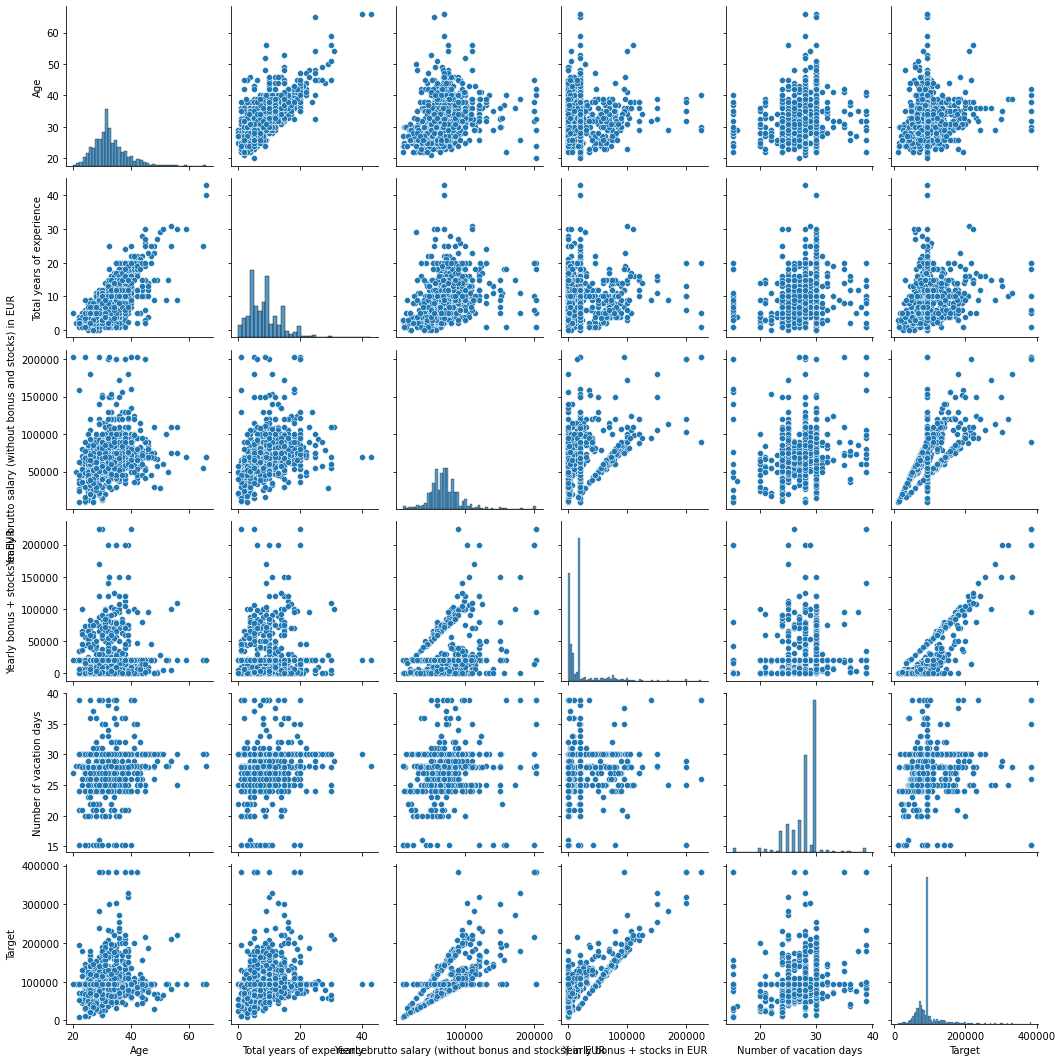

In [403]:
sns.pairplot(df)

<AxesSubplot:xlabel='Yearly brutto salary (without bonus and stocks) in EUR', ylabel='Density'>

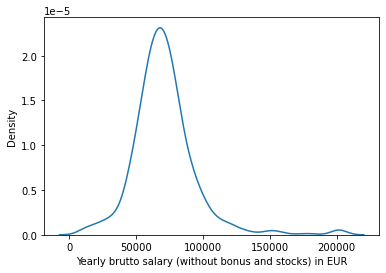

In [404]:
sns.kdeplot(data=df, x="Yearly brutto salary (without bonus and stocks) in EUR")

In [405]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.ensemble import RandomForestClassifier 

#Tree Based
tree_sel = RandomForestClassifier().fit(X, y)
sfm_class = SelectFromModel(tree_sel, prefit=True)
x_new = sfm_class.transform(X)
print(x_new.shape)

mask = sfm_class.get_support()
new_features = X.columns[mask]
print(new_features)
###
post_mut_inf = SelectPercentile(score_func=mutual_info_classif, percentile=50).fit_transform(X,y.ravel())
print("Mutual Info:", post_mut_inf.shape)

In [406]:
df.head()


,Age,Gender,City,Position,Total years of experience,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,Target
0,26.0,Male,Munich,Software Engineer,5.0,Senior,TypeScript,Other,80000.0,5000.000000,30.0,Full-time employee,Unlimited contract,English,51-100,Product,85000.000000
1,26.0,Male,Berlin,Backend Developer,7.0,Senior,Ruby,Javascript / Typescript,80000.0,20412.398438,28.0,Full-time employee,Unlimited contract,English,101-1000,Product,93092.820312
2,29.0,Male,Berlin,Software Engineer,12.0,Lead,Other,Other,120000.0,120000.000000,30.0,Self-employed (freelancer),Temporary contract,English,101-1000,Product,240000.000000
3,28.0,Male,Berlin,Frontend Developer,4.0,Junior,JavaScript,Javascript / Typescript,54000.0,20412.398438,24.0,Full-time employee,Unlimited contract,English,51-100,Startup,93092.820312
4,37.0,Male,Berlin,Backend Developer,17.0,Senior,Other,Other,62000.0,20412.398438,29.0,Full-time employee,Unlimited contract,English,101-1000,Product,93092.820312


In [466]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer


# Select the best features using mutual information
df = pd.get_dummies(df, drop_first=True)
y = df["Target"]
X = df.drop(columns={"Target","Yearly bonus + stocks in EUR","Yearly brutto salary (without bonus and stocks) in EUR"})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define the categorical and numerical features
numeric_features = X.select_dtypes(exclude="object").columns
numeric_transformer=Pipeline(steps=[
    #("imputer", SimpleImputer(strategy='mean')),
    ("Scaler", MinMaxScaler())])
categorical_features = X.select_dtypes(include="object").columns
categorical_transformer=OneHotEncoder(handle_unknown="ignore")

# Apply one-hot encoding to the categorical features and keep the numerical features as they are
preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_transformer,numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [463]:
model=DecisionTreeRegressor()
pipeline_steps = [('pre', preprocessor),('Reg', model) ]
clf = Pipeline(pipeline_steps)
clf=clf.fit(X_train,y_train)
print(model.get_depth())
print("Testing score: ", clf.score(X_test,y_test))
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


44
Testing score:  -0.32252948466072473
Mean Squared Error: 1913976310.037556


In [464]:
model2=DecisionTreeRegressor()
pipeline_steps2 = [('pre', preprocessor),('Reg', model2) ]
tree_para = {
             'max_depth':np.arange(10,30,2),
             'min_samples_split' :np.arange(20,30,1),
             'max_features' :np.arange(10,15,1),
             'ccp_alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7] 
             }
clf = GridSearchCV(estimator=model, param_grid=tree_para, cv=3)
clf.fit(X_train, y_train)
best=clf.best_estimator_
print(best.score(X_test,y_test))
best


-0.030237494808577736


DecisionTreeRegressor(ccp_alpha=0.7, max_depth=16, max_features=11,
                      min_samples_split=29)

In [471]:
iter_factor=4
model3=RandomForestRegressor(random_state=0)
pipeline_steps3 = [('pre', preprocessor),('Reg', model3) ]
pipe3=Pipeline(pipeline_steps3)
for_para={
    "max_depth": np.random.randint(5, 50, 10),
    "max_features": [3, 5, 7, "auto", "sqrt"],
    "min_samples_split": np.random.randint(2, 50, 20),
    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]
    }
search=GridSearchCV(pipe3, param_grid=for_para, cv=3,verbose=False,n_jobs=-1)
search.fit(X_train,y_train)
best3=search.best_estimator_
print(best3.score(X_test,y_test))
best3

TypeError: set_config() got an unexpected keyword argument 'pairwise_dist_chunk_size'

In [456]:
model4=LinearRegression()
pipeline_steps4 = [('pre', preprocessor),('Reg', model4) ]
pipe3=Pipeline(pipeline_steps4)
pipe3.fit(X_train,y_train)
print(pipe3.score(X_test,y_test))

-3.330149946192849e+25


In [474]:


# Train the model
pipeline_steps5 = [('pre', preprocessor),('SGD', SGDRegressor()) ]
pipe5 = Pipeline(pipeline_steps5)
pipe5.fit(X_train,y_train)
pipe5.fit(X_train,y_train)
cv=cross_val_score(pipe5,X_train, y_train.ravel(), cv=5)
print("Testing Score:", pipe5.score(X_test,y_test.ravel()))
y_pred = pipe5.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Testing Score: 0.13813055229577165
Mean Squared Error: 1247305050.1964612


In [476]:
pipeline_steps6 = [('pre', preprocessor),('SGD', Ridge()) ]
pipe6 = Pipeline(pipeline_steps6)
pipe6.fit(X_train,y_train)
pipe6.fit(X_train,y_train)
cv=cross_val_score(pipe6,X_train, y_train.ravel(), cv=5)
print("Testing Score:", pipe6.score(X_test,y_test.ravel()))
y_pred = pipe6.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Testing Score: 0.0752600039873369
Mean Squared Error: 1338291861.044225


In [501]:
from sklearn.linear_model import LogisticRegression
model7 = LogisticRegression(n_jobs=-1, solver="saga", max_iter=10000)
pipeline_steps7 = [('pre', preprocessor),('Model', model7) ]
pipe7= Pipeline(pipeline_steps7)

# Try different classifications for the multiple classes
params7 = {'log__multi_class':["ovr","multinomial"]}

clf = GridSearchCV(pipe7, param_grid=params7, cv=3, n_jobs=-1) 
clf.fit(X_train, y_train.ravel())
best = clf.best_estimator_
train_preds = best.predict(X_train)
print(best)
print(best.score(X_test, y_test))

TypeError: set_config() got an unexpected keyword argument 'pairwise_dist_chunk_size'

In [492]:
from sklearn.feature_selection import VarianceThreshold

var_th=VarianceThreshold(0.2)
var_fit=var_th.fit_transform(X)
mask=var_th.get_support()
new_features=X.columns[mask]
print(new_features)


Index(['Age', 'Total years of experience', 'Number of vacation days',
       'City_Berlin', 'Position _Software Engineer', 'Seniority level_Middle',
       'Seniority level_Senior',
       'Your main technology / programming language_Other',
       'Other technologies/programming languages you use often_Other',
       'Company size_101-1000', 'Company type_Product'],
      dtype='object')


<AxesSubplot:>

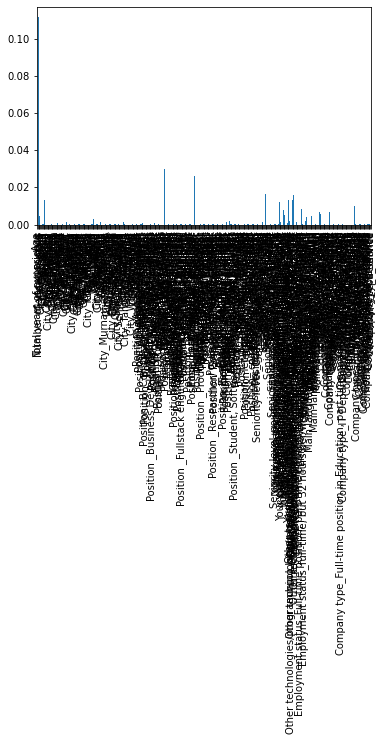

In [494]:
randFor = RandomForestRegressor()

randFor.fit(X,y)
feat_names = X.columns
for_imp = randFor.feature_importances_
forest_imp = pd.Series(for_imp, index=feat_names)
forest_imp.plot.bar()

In [495]:
lasso = Lasso()
x_reg_dum = pd.get_dummies(X, drop_first=True)
lasso.fit(x_reg_dum, y)
coeff = lasso.coef_
print("Zero'd:", np.array(x_reg_dum.columns)[coeff==0])
print("Kept:", np.array(x_reg_dum.columns)[coeff!=0])

Zero'd: ['City_Bölingen' 'City_Heilbronn' 'City_Kyiv' 'City_Zürich'
 'Position _Beikoch' 'Position _Business Development Manager Operations '
 'Position _DatabEngineer' 'Position _Product Management Praktikant'
 'Position _Program Manager' 'Position _Researcher'
 'Position _Robotics Engineer' 'Position _Scrum Master'
 'Position _Senior Scrum Master (RTE)' 'Position _Software tester '
 'Position _VP Engineering' 'Seniority level_Director'
 'Seniority level_Intern' 'Seniority level_No level'
 'Seniority level_No level ' 'Seniority level_Working Student'
 'Employment status_Full-time position, part-time position, & self-employed (freelancing, tutoring)'
 'Employment status_Intern' 'Employment status_Part-time employee'
 'Employment status_working student'
 'Сontract duration_Temporary contract'
 'Main language at work_Russian, English' 'Main language at work_Русский'
 'Company type_Biergarten ' 'Company type_Consulting / Agency'
 'Company type_Enterprise'
 'Company type_Full-time position

c:\Users\taraz\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+10, tolerance: 2.149e+08
  


In [496]:
from sklearn.feature_selection import SelectFromModel
l1_selection = Lasso(alpha=0.1).fit(x_reg_dum, y)
sfm = SelectFromModel(l1_selection, prefit=True)
x_reg_new = sfm.transform(x_reg_dum)
print(x_reg_new.shape)

mask = sfm.get_support()
new_features = x_reg_dum.columns[mask]
print(new_features)

(1253, 395)
Index(['Age', 'Total years of experience', 'Number of vacation days',
       'Gender_Female', 'Gender_Male', 'City_Amsterdam', 'City_Ansbach',
       'City_Barcelona', 'City_Basel', 'City_Berlin',
       ...
       'Company type_Systemhaus', 'Company type_Telecommunications',
       'Company type_Transport & Logistics', 'Company type_University',
       'Company type_Utilities', 'Company type_consumer goods',
       'Company type_corporate incubator', 'Company type_e-commerce',
       'Company type_eCommerce', 'Company type_service'],
      dtype='object', length=395)


c:\Users\taraz\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.120e+11, tolerance: 2.149e+08
  
c:\Users\taraz\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  """HTML representation of estimator.


In [500]:
from sklearn.feature_selection import RFECV
model = RandomForestRegressor(n_jobs=-1)
pipe_model = DecisionTreeRegressor()

min_features_to_select = 1  # Minimum number of features to consider
rfecv_pipe = RFECV(
    estimator=pipe_model,
    step=1,
    cv=3,
    min_features_to_select=min_features_to_select,
)

X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y)


pipeline_steps = [("fs", rfecv_pipe),
                ('model', model) ]
pipe = Pipeline(pipeline_steps)
pipe.fit(X_train_, y_train_)
pipe.score(X_test_,y_test_)

0.08130442247632652

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

pipeline_steps9 = [('pre', preprocessor),()"svm_clf", SVC(kernel="poly", degree=3, coef0=1) ]
pipe9 = Pipeline(pipeline_steps7)

# Try different classifications for the multiple classes
params = {'log__multi_class':["ovr","multinomial"]}

clf = GridSearchCV(pipe, param_grid=params, cv=3, n_jobs=-1) 
clf.fit(X_train, y_train.ravel())
best = clf.best_estimator_
train_preds = best.predict(X_train)
print(best)
print(best.score(X_test, y_test))


# Answers and Explainations
(Expand/modify as needed)

### Results

### Feature Selection Activities

### Hyperparameter Changes